# AGAMA satellite infall simulation

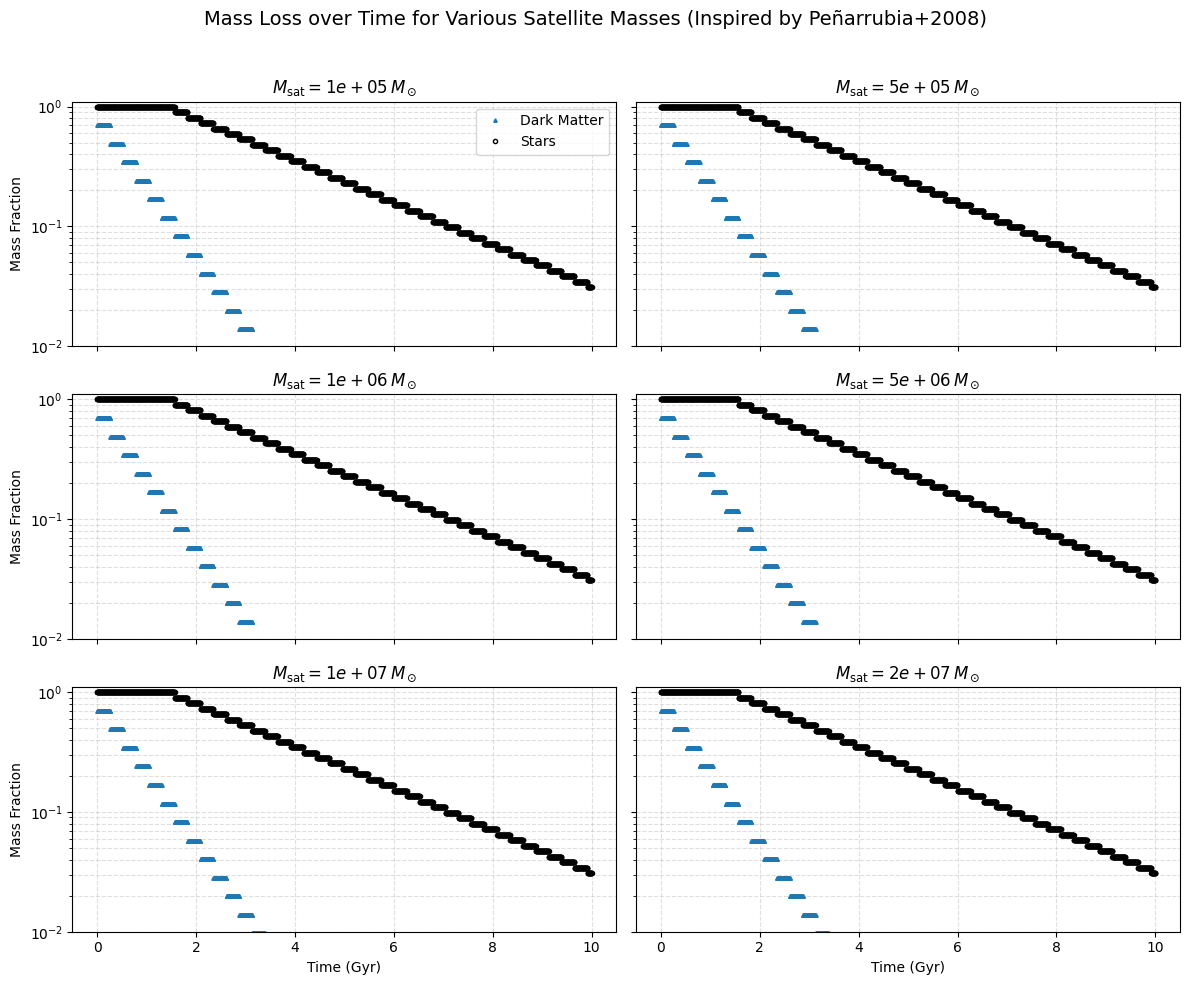

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import agama

# Setup: NFW halo potential for M31-like galaxy
halo = agama.Potential(type="NFW", mass=1.2e12, scaleRadius=90.0)

# Simulation parameters
n_steps = 2000
t_end = 10.0  # Gyr
times = np.linspace(0, t_end, n_steps)

# Common orbital configuration for r_peri : r_apo = 1:20
init_cond = [[60, 0, 0, 0, 35, 0]]
traj = agama.orbit(potential=halo, ic=init_cond, time=t_end, trajsize=n_steps)
traj_array = traj[0][1]

# Identify pericenters (local minima in radius)
R_arr = np.linalg.norm(traj_array[:, :3], axis=1)
pericenter_indices = []
for i in range(1, n_steps - 1):
    if R_arr[i] < R_arr[i - 1] and R_arr[i] < R_arr[i + 1]:
        if len(pericenter_indices) == 0 or i - pericenter_indices[-1] > 50:
            pericenter_indices.append(i)

# Simulation settings
mass_loss_dm = 0.3  # 30% per pericenter for dark matter
mass_loss_star = 0.1  # 10% per pericenter after DM is mostly stripped
stellar_fraction = 0.1

satellite_masses = [1e5, 5e5, 1e6, 5e6, 1e7, 2e7]
sim_results = {}

for mass_init in satellite_masses:
    M_dm_init = mass_init * (1 - stellar_fraction)
    M_star_init = mass_init * stellar_fraction
    M_dm = M_dm_init
    M_star = M_star_init

    mass_dm_frac = []
    mass_star_frac = []

    for i in range(n_steps):
        if i in pericenter_indices:
            if M_dm > 0:
                M_dm *= (1 - mass_loss_dm)
                if M_dm / M_dm_init < 0.1:  # Stars start stripping once DM is <10% original
                    M_star *= (1 - mass_loss_star)


        mass_dm_frac.append(M_dm / M_dm_init)
        mass_star_frac.append(M_star / M_star_init)

    sim_results[mass_init] = (mass_dm_frac, mass_star_frac)

# Plotting: 3x2 grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (mass, (dm, star)) in enumerate(sim_results.items()):
    ax = axes[idx]
    ax.plot(times, dm, '^', markersize=2.5, label="Dark Matter")
    ax.plot(times, star, 'o', markerfacecolor='none', markeredgecolor='black', markersize=3, label="Stars")
    ax.set_yscale("log")
    ax.set_title(f"$M_{{\\rm sat}} = {mass:.0e} \\, M_\\odot$")
    ax.grid(True, which="both", ls="--", alpha=0.4)
    ax.set_ylim(1e-2, 1.1)
    ax.set_yscale("log")
    ax.set_yticks([1e-2, 1e-1, 1])  # Optional: cleaner tick locations
    if idx == 0:
        ax.legend()
    if idx % 2 == 0:
        ax.set_ylabel("Mass Fraction")

axes[-2].set_xlabel("Time (Gyr)")
axes[-1].set_xlabel("Time (Gyr)")
plt.suptitle("Mass Loss over Time for Various Satellite Masses (Inspired by Peñarrubia+2008)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
